In [21]:
# Setup env variables
import dotenv
import os
dotenv.load_dotenv(".env", override=True)
print('LD_PRELOAD = ', os.environ.get('LD_PRELOAD')) # MY_VAR = HELLO_BOB

LD_PRELOAD =  /usr/local/lib/python3.8/dist-packages/torch/lib/libgomp-d22c30c5.so.1


In [22]:
# import libraries
from tensortrade.oms.instruments import Instrument
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import PBR
from tensortrade.env import default
from tensortrade.env.generic import Renderer
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Extension imports
import sys
sys.path.append("..")

from tensortradeExtension.env.generic.components.renderer.positionChangeChart import PositionChangeChart
from tensortradeExtension.data.sine import SineWaveDataGenerator

In [24]:
# run configuration
window_size = 30

In [25]:
# Setup Instruments
USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 2, "TensorTrade Coin")

In [27]:
# Create the environement
def create_env():
    sine_wave_data_generator = SineWaveDataGenerator()
    dataframe = sine_wave_data_generator.fetch()
    price_stream = Stream.source(list(dataframe['price']), dtype="float").rename("USD-TTC")
    sinewavee_xchange = Exchange("sine-wave", service=execute_order, options=ExchangeOptions(commission=0.00075))(
        price_stream
    )
    cash = Wallet(sinewavee_xchange, 100 * USD)
    asset = Wallet(sinewavee_xchange, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        price_stream,
        price_stream.rolling(window=10).mean().rename("fast"),
        price_stream.rolling(window=50).mean().rename("medium"),
        price_stream.rolling(window=100).mean().rename("slow"),
        price_stream.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=price_stream)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(dataframe, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=window_size,
        max_allowed_loss=0.6
    )
    return environment

# Instantiate the environment
env = create_env()

#environment details
print("Action Space: "+str(env.action_space))
print("State Space: "+str(env.observation_space.shape))
print("Next observation")
env.observer.feed.next()

Action Space: Discrete(2)
State Space: (30, 5)
Next observation


{'internal': {'sine-wave:/USD-TTC': 100.0,
  'sine-wave:/USD:/free': 100.0,
  'sine-wave:/USD:/locked': 0.0,
  'sine-wave:/USD:/total': 100.0,
  'sine-wave:/TTC:/free': 0.0,
  'sine-wave:/TTC:/locked': 0.0,
  'sine-wave:/TTC:/total': 0.0,
  'sine-wave:/TTC:/worth': 0.0,
  'net_worth': 100.0},
 'external': {'sine-wave:/USD-TTC': 100.0,
  'fast': 100.0,
  'medium': 100.0,
  'slow': 100.0,
  'lr': 0},
 'renderer': {'price': 'price', 'action': 0}}

In [28]:
# calculate the batch size
def get_optimal_batch_size(window_size=30, n_steps=1000, batch_factor=4, stride=1):
    """
    lookback = 30          # Days of past data (also named window_size).
    batch_factor = 4       # batch_size = (sample_size - lookback - stride) // batch_factor
    stride = 1             # Time series shift into the future.
    """
    lookback = window_size
    sample_size = n_steps
    batch_size = ((sample_size - lookback - stride) // batch_factor)
    return batch_size

batch_size = get_optimal_batch_size()

In [29]:
# Agents
# Baseline PPO Agent
from stable_baselines3 import DQN

import torch as th

n_steps = 1000
n_episodes = 10
render_interval = 1000
save_path = "models/tests/sinewave/dqn"

# Save a checkpoint every 1000 steps
# checkpoint_callback = CheckpointCallback(save_freq=100000, save_path="models/tests/sinewave/dqn-ml-bsh-pbr",
#                                          name_prefix="ml-bsh-pbr")

# policy_kwargs = dict(activation_fn=th.nn.Tanh,
                    #  net_arch=[dict(pi=[32, 32], vf=[32, 32])])



/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  buy = pd.Series(buy)
/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


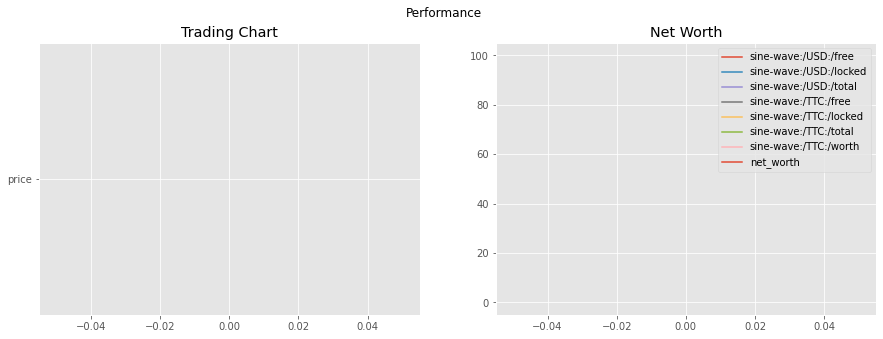

/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  buy = pd.Series(buy)
/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


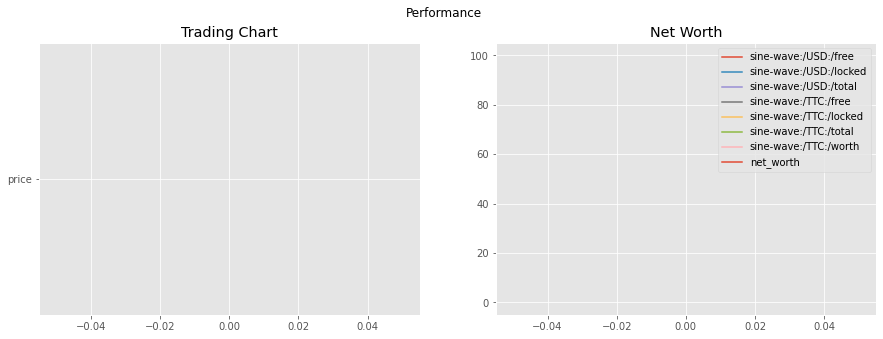

/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  buy = pd.Series(buy)
/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


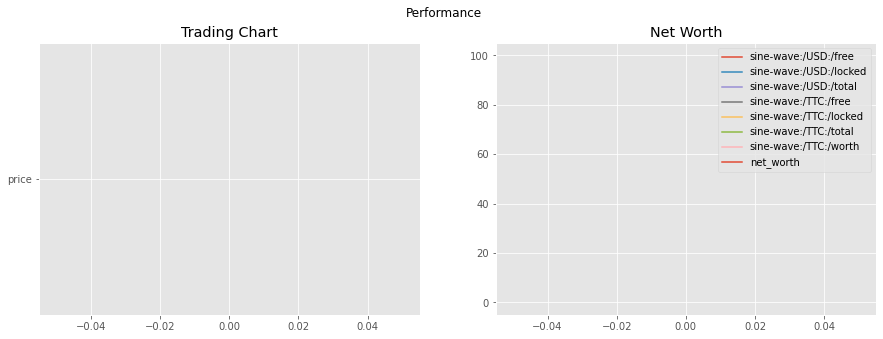

/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  buy = pd.Series(buy)
/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


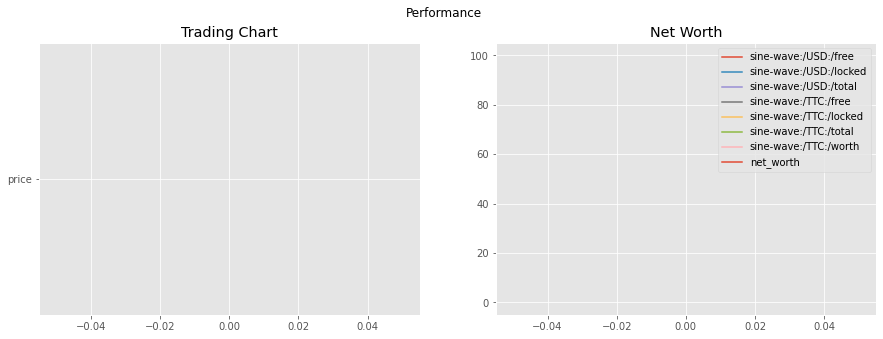

/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  buy = pd.Series(buy)
/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


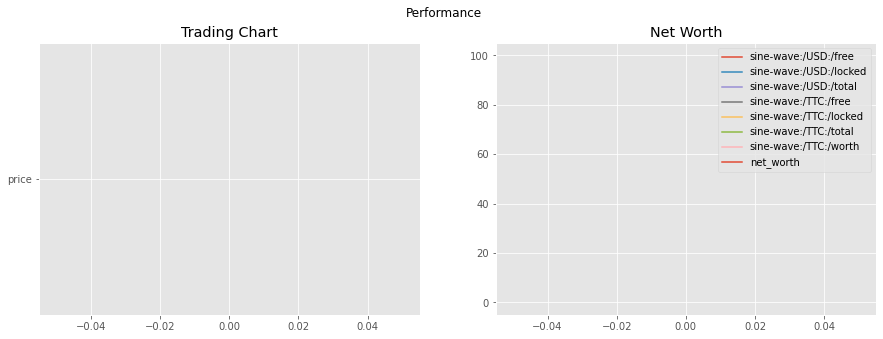

Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00
Episode length: 1.00 +/- 0.00
New best mean reward!


In [32]:
# train agent
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor

eval_env = Monitor(env)

eval_callback = EvalCallback(
  env,
  best_model_save_path="models/tests/sinewave/dqn-mlp-bsh-pbr",
  log_path="./logs/",
  eval_freq=1000,
  deterministic=True, render=True)

env.reset()
agent.learn(total_timesteps=n_steps, callback=eval_callback)

/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  buy = pd.Series(buy)
/workspaces/masters-code/Experiments/../tensortradeExtension/env/generic/components/renderer/positionChangeChart.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


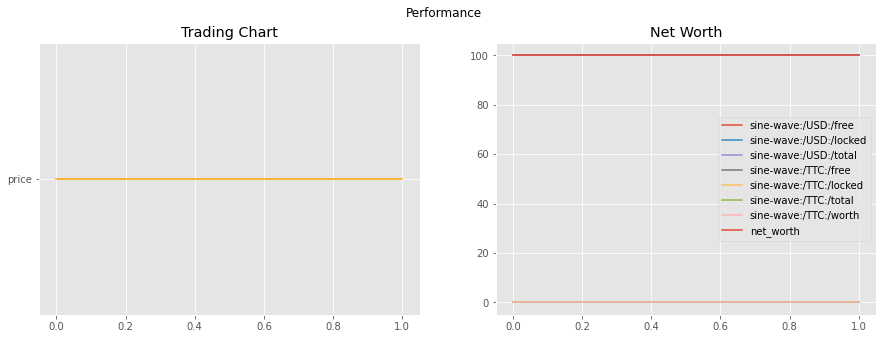

In [10]:
# Test the environment
# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action, _state = agent.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()